#### Mimik Testdatananalyse für Korrelationsvergleich. 

In [4]:
import datetime
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications import DenseNet169

# TensorFlow Warnungen unterdrücken
tf.get_logger().setLevel('ERROR')

# Betitelung für Tensorboard
experiment_name = "DenseNet169_Korrelationsanalyse"

# Data Augmentation Layer hinzufügen
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),  # Rotation um bis zu 20%
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),  # Horizontaler und vertikaler Flip
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),  # Zufällige Kontrastanpassung
])

# Funktion zur Vorbereitung und Augmentation der Bilder
def preprocess_and_augment_dataset(ds):
    # Zuerst Data Augmentation anwenden
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    # Dann die spezifische Vorverarbeitung für DenseNet anwenden
    return ds.map(lambda x, y: (preprocess_input(x), y))

# Funktion zur Vorbereitung der Testdaten
def preprocess_dataset(ds):
    return ds.map(lambda x, y: (preprocess_input(x), y))    

# Trainingsdaten laden und vorbereiten
train_ds = image_dataset_from_directory(
    "C:\\Thesis\\Data\\Frames\\Facial_Expressions",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32)

# Anwendung der Vorverarbeitung und Augmentation auf Trainingsdaten
train_ds = preprocess_and_augment_dataset(train_ds)

# Validierungsdaten laden und vorbereiten
val_ds = image_dataset_from_directory(
    "C:\\Thesis\\Data\\Frames\\Facial_Expressions",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32)

# Anwendung der Vorverarbeitung (ohne Augmentation) auf Validierungsdaten
val_ds = preprocess_and_augment_dataset(val_ds) 

# Vortrainiertes Modell laden
base_model = DenseNet169(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Einfrieren der Basis-Schichten

# Modell anpassen
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)  # 4 Klassen für Emotionen
model = Model(inputs, outputs)

# Modell kompilieren und trainieren
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Setze den Pfad für die TensorBoard Logs
log_dir = "logs/fit/" + experiment_name + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, update_freq="epoch")

model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=2, 
    callbacks=[tensorboard_callback]
)

# Funktion, um ein einzelnes Bild zu laden und vorzubereiten
def load_and_prepare_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded_dims)

# Liste für die Ergebnisse
results = []

# Emotionen, die das Modell erkennen kann
emotion_labels = ['Angst', 'Ekel', 'Trauer', 'Freude']

# Pfad zum zusätzlichen Testdataset
test_data_path = "C:/Users/zastr/Desktop/Thesis/Data/Testdata/Mimik"

# Vorhersagen für jedes Bild im Testset machen und in der Liste speichern
for emotion in emotion_labels:
    emotion_path = os.path.join(test_data_path, emotion)
    for img_file in os.listdir(emotion_path):
        img_path = os.path.join(emotion_path, img_file)
        img_prepared = load_and_prepare_image(img_path)
        predictions = model.predict(img_prepared)[0]  # Nimmt die Vorhersagen für das erste (und einzige) Bild
        
        # Erstelle ein Dictionary mit den Ergebnissen
        result_dict = {'Bild': img_file}
        for i, label in enumerate(emotion_labels):
            result_dict[f'Mimik_{label}'] = predictions[i]
            
        # Füge das Dictionary zur Liste hinzu
        results.append(result_dict)

# Konvertiere die Liste in einen DataFrame
results_df = pd.DataFrame(results)


Found 2508 files belonging to 4 classes.
Using 2007 files for training.
Found 2508 files belonging to 4 classes.
Using 501 files for validation.
Epoch 1/2
63/63 [==============================] - 19s 225ms/step - loss: 1.1098 - accuracy: 0.6004 - val_loss: 0.6464 - val_accuracy: 0.7405
Epoch 2/2
1/1 [==============================] - 0s 49ms/step
            Bild  Mimik_Angst  Mimik_Ekel  Mimik_Trauer  Mimik_Freude
0     Angst1.jpg     0.004902    0.802343      0.000085      0.192671
1    Angst10.jpg     0.385311    0.346157      0.005886      0.262646
2    Angst11.jpg     0.300877    0.054586      0.006065      0.638472
3    Angst12.jpg     0.386857    0.076580      0.019972      0.516591
4     Angst2.jpg     0.037351    0.098008      0.023535      0.841106
5     Angst3.jpg     0.136606    0.588638      0.082707      0.192049
6     Angst4.jpg     0.147556    0.816635      0.001039      0.034770
7     Angst5.jpg     0.057070    0.854724      0.009547      0.078659
8     Angst6.jpg     

In [5]:
# Zeige finalen Dataframe
print(results_df)

            Bild  Mimik_Angst  Mimik_Ekel  Mimik_Trauer  Mimik_Freude
0     Angst1.jpg     0.004902    0.802343      0.000085      0.192671
1    Angst10.jpg     0.385311    0.346157      0.005886      0.262646
2    Angst11.jpg     0.300877    0.054586      0.006065      0.638472
3    Angst12.jpg     0.386857    0.076580      0.019972      0.516591
4     Angst2.jpg     0.037351    0.098008      0.023535      0.841106
5     Angst3.jpg     0.136606    0.588638      0.082707      0.192049
6     Angst4.jpg     0.147556    0.816635      0.001039      0.034770
7     Angst5.jpg     0.057070    0.854724      0.009547      0.078659
8     Angst6.jpg     0.224806    0.183880      0.001163      0.590150
9     Angst7.jpg     0.207850    0.082424      0.004300      0.705425
10    Angst8.jpg     0.232600    0.201865      0.000848      0.564686
11    Angst9.jpg     0.492850    0.309893      0.003536      0.193722
12     Ekel1.jpg     0.000904    0.993639      0.000383      0.005074
13    Ekel10.jpg    

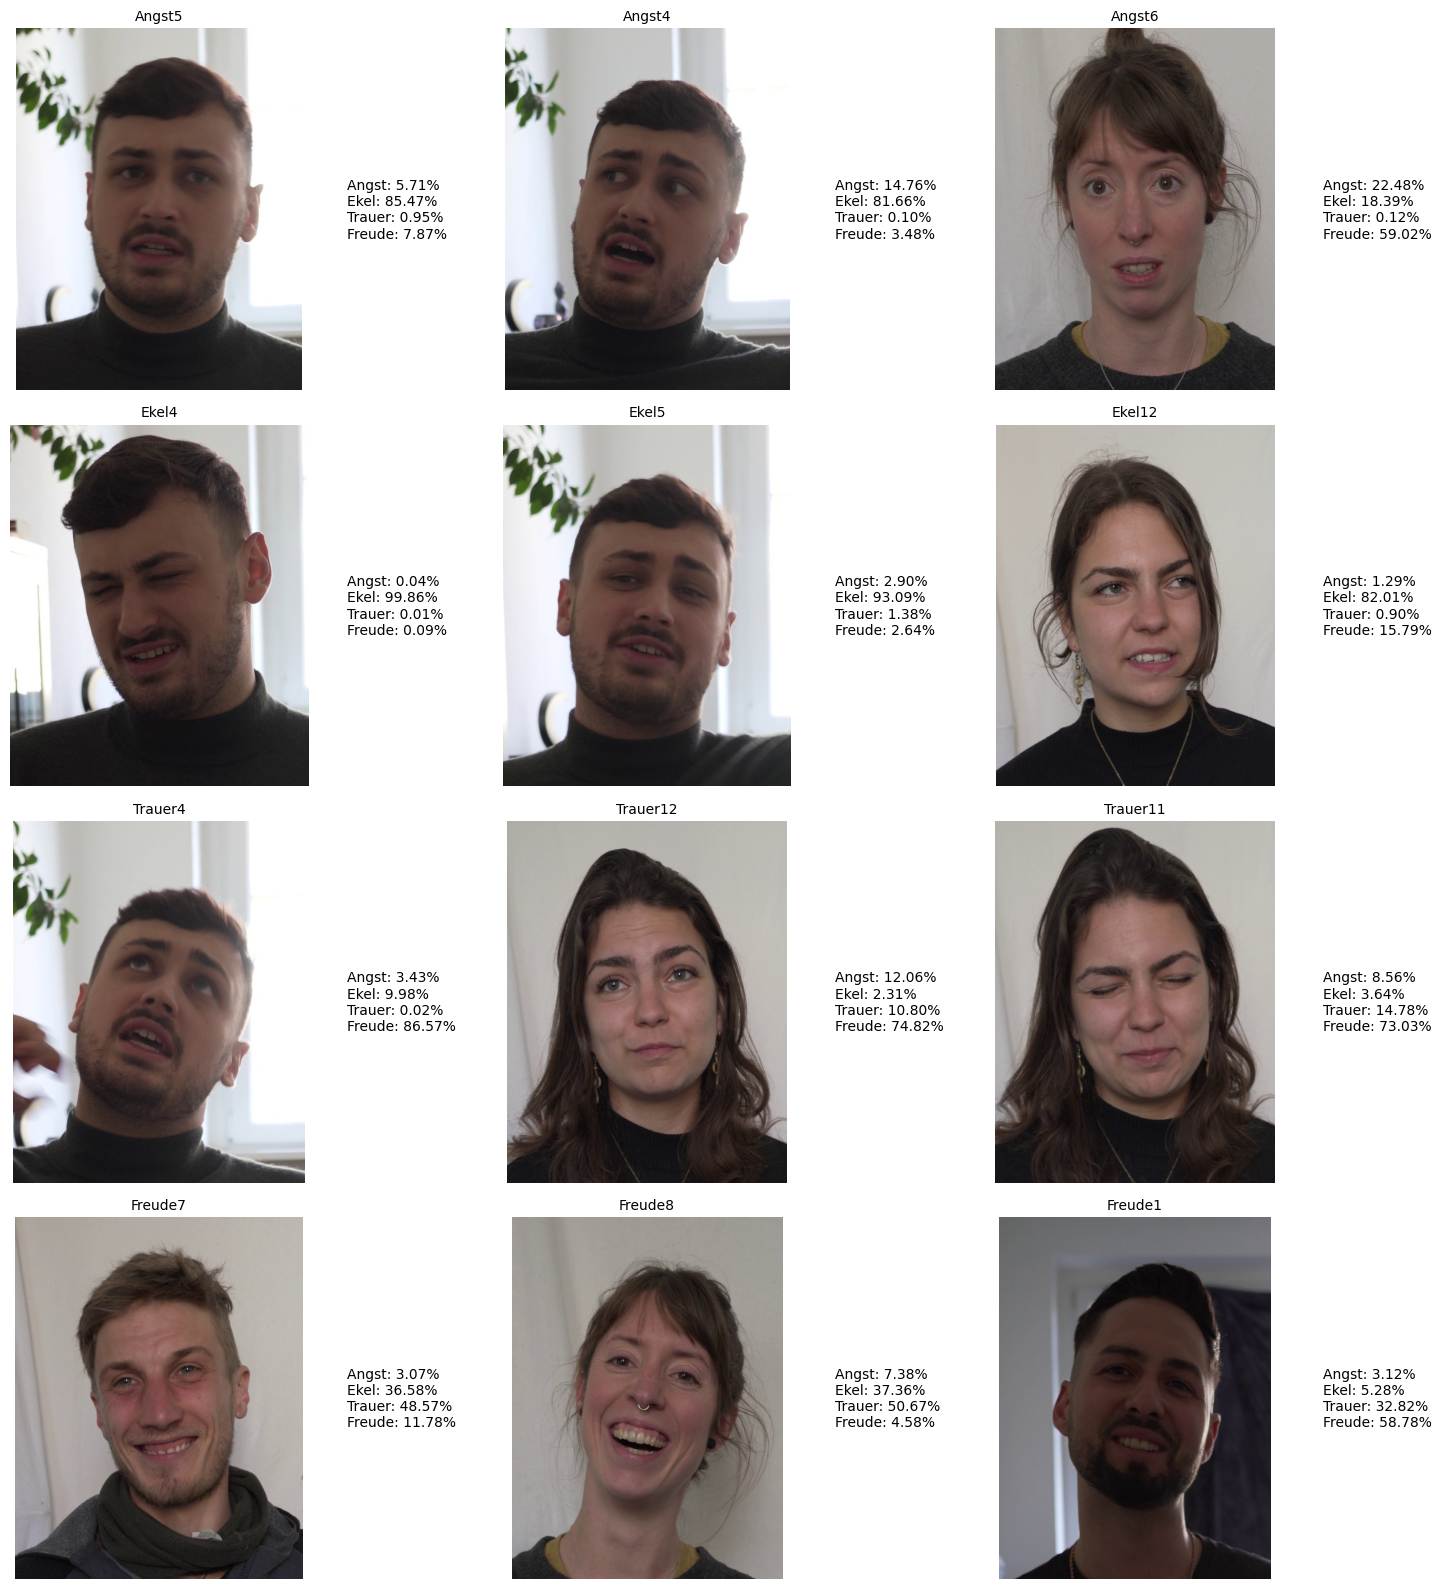

In [10]:
import matplotlib.pyplot as plt

# Wähle drei Bilder pro Emotion aus
samples_per_emotion = 3

# Anzahl der Reihen und Spalten für das Grid festlegen
rows = len(emotion_labels)
cols = samples_per_emotion * 2  # Verdopple die Spalten für Text

# Erstelle eine Figure für die Ausgabe
fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 4), gridspec_kw={'width_ratios': [3, 1] * samples_per_emotion})

# Sorge dafür, dass axs bei nur einer Reihe nicht flach ist
if rows == 1:
    axs = [axs]

for i, emotion in enumerate(emotion_labels):
    df_filtered = results_df[results_df['Bild'].str.contains(emotion)].sample(n=samples_per_emotion)
    
    for j in range(samples_per_emotion):
        row = df_filtered.iloc[j]
        img_path = os.path.join(test_data_path, emotion, row['Bild'])
        img = plt.imread(img_path)
        
        # Bild anzeigen
        ax_img = axs[i][j * 2]  # Achse für das Bild
        ax_img.imshow(img)
        ax_img.axis('off')  # Bildachsen ausschalten
        ax_img.set_title(row['Bild'].split('.')[0], fontsize=10)  # Bildtitel ohne Dateiendung
        
        # Text rechts vom Bild anzeigen
        ax_text = axs[i][j * 2 + 1]  # Achse für den Text
        text_str = "\n".join([f"{emotion}: {row[f'Mimik_{emotion}'] * 100:.2f}%" for emotion in emotion_labels])
        ax_text.text(0, 0.5, text_str, fontsize=10, ha='left', va='center', transform=ax_text.transAxes)
        ax_text.axis('off')  # Textachsen ausschalten

plt.tight_layout()
plt.show()


#### Sprache Testdatananalyse für Korrelationsvergleich. 

In [ ]:
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# TensorFlow Warnungen unterdrücken (optional)
tf.get_logger().setLevel('ERROR')

# Eager Execution aktivieren
tf.config.run_functions_eagerly(True)

# Funktion zur Extraktion der Audio-Features
def extract_audio_features(file_path, n_fft=512):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    features = np.hstack((np.mean(mfccs, axis=1), 
                          np.mean(librosa.power_to_db(mel_spectrogram), axis=1),
                          np.mean(chromagram, axis=1),
                          np.mean(spectral_contrast, axis=1),
                          np.mean(tonnetz, axis=1)))
    return features

# Daten und Labels laden
def load_data_and_labels(base_path):
    emotions = {'Angst': 0, 'Ekel': 1, 'Trauer': 2, 'Freude': 3}
    features_list = []
    labels_list = []
    for emotion, label in emotions.items():
        emotion_path = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                features_list.append(features)
                labels_list.append(label)
    return np.array(features_list), np.array(labels_list)

# CNN Modelldefinition mit L2-Regularisierung und erweiterten Schichten
def build_model(input_shape, number_of_classes):
    model = Sequential([
        Conv1D(256, 5, padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(number_of_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
    return model

# Hauptskript
base_path = r'C:\Users\zastr\Desktop\Thesis\Data\Audio\Emo_DB'
features, labels = load_data_and_labels(base_path)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(2/3), random_state=42)

model = build_model((193, 1), len(np.unique(labels)))

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[reduce_lr])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

# Zusätzliche Funktion, um das zusätzliche Testdataset zu laden und vorzubereiten
def load_and_prepare_test_data(test_data_path):
    emotions = {'Angst': 0, 'Ekel': 1, 'Trauer': 2, 'Freude': 3}
    test_features_list = []
    test_labels_list = []
    test_filenames = []
    for emotion, label in emotions.items():
        emotion_path = os.path.join(test_data_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                test_features_list.append(features)
                test_labels_list.append(label)
                test_filenames.append(f"Sprache_{emotion}_{filename.split('.')[0]}")  # Ohne Dateiendung
    test_features = np.array(test_features_list)
    test_features = np.expand_dims(test_features, axis=-1)  # Korrigiere die Achse hier
    return test_features, np.array(test_labels_list), test_filenames

# Vorhersagen für das zusätzliche Testdataset machen und Ergebnisse als DataFrame speichern
test_data_path = r'C:\Users\zastr\Desktop\Thesis\Data\Testdata\Sprache'
test_features, test_labels, test_filenames = load_and_prepare_test_data(test_data_path)

predictions = model.predict(test_features)

# DataFrame mit den Ergebnissen erstellen
results_df = pd.DataFrame(predictions, columns=['Mimik_Angst', 'Mimik_Ekel', 'Mimik_Trauer', 'Mimik_Freude'])
results_df.insert(0, 'Dateiname', test_filenames)

# Ergebnisse anzeigen
print(results_df.head())


In [25]:
import os
import numpy as np
import librosa
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# TensorFlow Warnungen unterdrücken (optional)
tf.get_logger().setLevel('ERROR')

# Funktion zur Extraktion der Audio-Features mit erhöhten Merkmalen
def extract_audio_features(file_path, max_feature_length=None):
    y, sr = librosa.load(file_path)
    
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    
    # Spektrogramm
    spectrogram = np.abs(librosa.stft(y))
    
    # Mel-Frequenz-Cepstral-Koeffizienten Delta und Delta-Delta
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # Merkmale hinzufügen
    features = np.vstack((mfccs, delta_mfccs, delta2_mfccs, spectrogram))
    
    # Anpassen der Länge der Merkmale, wenn max_feature_length angegeben ist
    if max_feature_length:
        if features.shape[1] < max_feature_length:
            padding_width = max_feature_length - features.shape[1]
            features = np.pad(features, ((0, 0), (0, padding_width)), mode='constant')
        else:
            features = features[:, :max_feature_length]
    
    return features

def load_data_and_labels(base_path):
    emotions = {'Angst': 0, 'Ekel': 1, 'Trauer': 2, 'Freude': 3}
    features_list = []
    labels_list = []
    max_feature_length = 0  # Initialisierung der maximalen Merkmalslänge
    for emotion, label in emotions.items():
        emotion_path = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                feature_length = features.shape[1]
                if feature_length > max_feature_length:
                    max_feature_length = feature_length
                features_list.append(features)
                labels_list.append(label)
    # Auffüllen oder Abschneiden der Merkmale auf die maximale Länge
    features_list = [np.pad(features, ((0, 0), (0, max_feature_length - features.shape[1])), mode='constant') for features in features_list]
    return np.array(features_list), np.array(labels_list)



# CNN Modelldefinition mit L2-Regularisierung und erweiterten Schichten
def build_model(input_shape, number_of_classes):
    model = Sequential([
        Conv1D(256, 5, padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(number_of_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hauptskript
base_path = r'C:\Users\zastr\Desktop\Thesis\Data\Audio\Emo_DB'

# Laden der Daten und Labels unter Verwendung der definierten input_shape
features, labels = load_data_and_labels(base_path)

# Festlegen der maximalen Länge der Merkmale
max_feature_length = max([feature.shape[1] for feature in features])

# Anpassen des Input-Shape für das CNN-Modell
input_shape = (features.shape[1], features.shape[2])  

# Aufteilen der Daten in Trainings-, Validierungs- und Testsets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# Erstellen des Modells unter Verwendung der definierten input_shape
model = build_model(input_shape, len(np.unique(labels)))

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Training des Modells und Vorhersagen auf Testdaten
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[reduce_lr])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

def predict_on_test_data(test_data_path, model, max_feature_length=None):
    emotions = ['Angst', 'Ekel', 'Trauer', 'Freude']
    results = []
    for emotion in emotions:
        emotion_path = os.path.join(test_data_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path, max_feature_length=max_feature_length)
                features = np.expand_dims(features, axis=-1)  # Hinzufügen der Kanaldimension
                prediction = model.predict(np.array([features]))[0]
                predicted_emotion = emotions[np.argmax(prediction)]
                # Umbenennung der Spalten und Anpassung der Spaltennamen mit Präfix "Sprache_"
                results.append({'Bild': filename, 
                                'Wahre Emotion': emotion, 
                                'Vorhergesagte Emotion': predicted_emotion, 
                                'Sprache_Angst': prediction[0], 
                                'Sprache_Ekel': prediction[1], 
                                'Sprache_Trauer': prediction[2], 
                                'Sprache_Freude': prediction[3]})
    return pd.DataFrame(results)

# Pfad zum zusätzlichen Testdataset
test_data_path = r"C:\Users\zastr\Desktop\Thesis\Data\Testdata_wav\Sprache"

# Vorhersagen machen
results_df = predict_on_test_data(test_data_path, model, max_feature_length=max_feature_length)

# Ergebnisse anzeigen
print(results_df)


Epoch 1/10
6/6 [==============================] - 3s 221ms/step - loss: 2.5397 - accuracy: 0.4046 - val_loss: 3.1855 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 2/10
6/6 [==============================] - 0s 82ms/step - loss: 1.8319 - accuracy: 0.5896 - val_loss: 2.2292 - val_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 3/10
6/6 [==============================] - 0s 79ms/step - loss: 1.7754 - accuracy: 0.6243 - val_loss: 2.1069 - val_accuracy: 0.6800 - lr: 1.0000e-04
Epoch 4/10
6/6 [==============================] - 0s 76ms/step - loss: 1.4613 - accuracy: 0.7399 - val_loss: 2.0478 - val_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 5/10
6/6 [==============================] - 0s 70ms/step - loss: 1.2734 - accuracy: 0.8844 - val_loss: 2.4235 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 6/10
6/6 [==============================] - 0s 67ms/step - loss: 1.2399 - accuracy: 0.8497 - val_loss: 2.1864 - val_accuracy: 0.5600 - lr: 1.0000e-04
Epoch 7/10
6/6 [==============================] - 0s 66ms/step 

In [27]:
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

Test accuracy: 0.6800000071525574, Test loss: 1.9056986570358276


In [26]:
print(results_df)

            Bild Wahre Emotion Vorhergesagte Emotion  Sprache_Angst  \
0     Angst1.wav         Angst                Trauer   0.0002864578   
1    Angst10.wav         Angst                Trauer   0.0000123411   
2    Angst11.wav         Angst                Trauer   0.0000133534   
3    Angst12.wav         Angst                Trauer   0.0000263503   
4     Angst2.wav         Angst                Trauer   0.0001101384   
5     Angst3.wav         Angst                Trauer   0.0000006657   
6     Angst4.wav         Angst                Trauer   0.0001740988   
7     Angst5.wav         Angst                Trauer   0.0000141447   
8     Angst6.wav         Angst                Freude   0.0000067076   
9     Angst7.wav         Angst                Freude   0.0802354589   
10    Angst8.wav         Angst                Trauer   0.0000489373   
11    Angst9.wav         Angst                Trauer   0.0000060929   
12     Ekel1.wav          Ekel                Trauer   0.0000207441   
13    

In [22]:
import os
import numpy as np
import librosa
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# TensorFlow Warnungen unterdrücken (optional)
tf.get_logger().setLevel('ERROR')

# Funktion zur Extraktion der Audio-Features mit erhöhten Merkmalen
def extract_audio_features(file_path, n_fft=512):
    y, sr = librosa.load(file_path)
    
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    
    # Spektrogramm
    spectrogram = np.abs(librosa.stft(y))
    
    # Mel-Frequenz-Cepstral-Koeffizienten Delta und Delta-Delta
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # Merkmale hinzufügen
    features = np.vstack((mfccs, delta_mfccs, delta2_mfccs, spectrogram))
    
    return features

def load_data_and_labels(base_path, input_shape):
    emotions = {'Angst': 0, 'Ekel': 1, 'Trauer': 2, 'Freude': 3}
    features_list = []
    labels_list = []
    max_feature_length = input_shape[0]  # Maximal zulässige Länge der Features
    for emotion, label in emotions.items():
        emotion_path = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                # Auffüllen der Features, wenn die Länge kleiner als die maximale Länge ist
                if features.shape[1] < max_feature_length:
                    padding_width = max_feature_length - features.shape[1]
                    features = np.pad(features, ((0, 0), (0, padding_width)), mode='constant')
                features_list.append(features)
                labels_list.append(label)
    return np.array(features_list), np.array(labels_list)

# CNN Modelldefinition mit L2-Regularisierung und erweiterten Schichten
def build_model(input_shape, number_of_classes):
    model = Sequential([
        Conv1D(256, 5, padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(number_of_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hauptskript
base_path = r'C:\Users\zastr\Desktop\Thesis\Data\Audio\Emo_DB'

# Definition der input_shape entsprechend der Form der extrahierten Audiofeatures
Anzahl_der_Zeitpunkte = 1000
Anzahl_der_Merkmale_pro_Zeitpunkt = 40
input_shape = (Anzahl_der_Zeitpunkte, Anzahl_der_Merkmale_pro_Zeitpunkt)

# Laden der Daten und Labels unter Verwendung der definierten input_shape
features, labels = load_data_and_labels(base_path, input_shape)

# Aufteilen der Daten in Trainings-, Validierungs- und Testsets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# Anpassen des Input-Shape für das CNN-Modell
input_shape = (X_train.shape[1], X_train.shape[2])  

# Erstellen des Modells unter Verwendung der definierten input_shape
model = build_model(input_shape, len(np.unique(labels)))

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Training des Modells und Vorhersagen auf Testdaten
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[reduce_lr])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

def predict_on_test_data(test_data_path, model):
    emotions = ['Angst', 'Ekel', 'Trauer', 'Freude']
    results = []
    for emotion in emotions:
        emotion_path = os.path.join(test_data_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                max_feature_length = features.shape[1]
                features = np.pad(features, ((0, 0), (0, max_feature_length - input_shape[1])), mode='constant')
                features = np.expand_dims(features, axis=-1)  # Hinzufügen der Kanaldimension
                prediction = model.predict(np.array([features]))[0]
                predicted_emotion = emotions[np.argmax(prediction)]
                # Umbenennung der Spalten und Anpassung der Spaltennamen mit Präfix "Sprache_"
                results.append({'Bild': filename, 
                                'Wahre Emotion': emotion, 
                                'Vorhergesagte Emotion': predicted_emotion, 
                                'Sprache_Angst': prediction[0], 
                                'Sprache_Ekel': prediction[1], 
                                'Sprache_Trauer': prediction[2], 
                                'Sprache_Freude': prediction[3]})
    return pd.DataFrame(results)

# Pfad zum zusätzlichen Testdataset
test_data_path = r"C:\Users\zastr\Desktop\Thesis\Data\Testdata_wav\Sprache"

# Vorhersagen machen
results_df = predict_on_test_data(test_data_path, model)

# Ergebnisse anzeigen
print(results_df)


Epoch 1/10
6/6 [==============================] - 3s 224ms/step - loss: 2.6534 - accuracy: 0.2948 - val_loss: 2.4696 - val_accuracy: 0.3600 - lr: 1.0000e-04
Epoch 2/10
6/6 [==============================] - 1s 126ms/step - loss: 1.9710 - accuracy: 0.5607 - val_loss: 2.7520 - val_accuracy: 0.3600 - lr: 1.0000e-04
Epoch 3/10
6/6 [==============================] - 1s 116ms/step - loss: 1.6469 - accuracy: 0.7052 - val_loss: 2.2214 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 4/10
6/6 [==============================] - 1s 111ms/step - loss: 1.4723 - accuracy: 0.7803 - val_loss: 2.2212 - val_accuracy: 0.5600 - lr: 1.0000e-04
Epoch 5/10
6/6 [==============================] - 1s 106ms/step - loss: 1.3137 - accuracy: 0.8613 - val_loss: 2.2950 - val_accuracy: 0.4800 - lr: 1.0000e-04
Epoch 6/10
6/6 [==============================] - 1s 101ms/step - loss: 1.2425 - accuracy: 0.8728 - val_loss: 2.1828 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 7/10
6/6 [==============================] - 1s 99ms/

ValueError: index can't contain negative values

In [9]:
import os
import numpy as np
import librosa
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# TensorFlow Warnungen unterdrücken (optional)
tf.get_logger().setLevel('ERROR')
# Funktion zur Extraktion der Audio-Features mit erhöhten Merkmalen
def extract_audio_features(file_path, n_fft=512):
    y, sr = librosa.load(file_path)
    
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    
    # Spektrogramm
    spectrogram = np.abs(librosa.stft(y))
    
    # Mel-Frequenz-Cepstral-Koeffizienten Delta und Delta-Delta
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # Merkmale hinzufügen
    features = np.vstack((mfccs, delta_mfccs, delta2_mfccs, spectrogram))
    
    return features

# Aktualisierte Version der load_data_and_labels-Funktion
def load_data_and_labels(base_path):
    emotions = {'Angst': 0, 'Ekel': 1, 'Trauer': 2, 'Freude': 3}
    features_list = []
    labels_list = []
    max_feature_length = 0  
    for emotion, label in emotions.items():
        emotion_path = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                max_feature_length = max(max_feature_length, features.shape[1])
                features_list.append(features)
                labels_list.append(label)
    for i in range(len(features_list)):
        features_list[i] = np.pad(features_list[i], ((0, 0), (0, max_feature_length - features_list[i].shape[1])), mode='constant')
    return np.array(features_list), np.array(labels_list)


# CNN Modelldefinition mit L2-Regularisierung und erweiterten Schichten
def build_model(input_shape, number_of_classes):
    model = Sequential([
        Conv1D(256, 5, padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(number_of_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hauptskript
base_path = r'C:\Users\zastr\Desktop\Thesis\Data\Audio\Emo_DB'
features, labels = load_data_and_labels(base_path)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

model = build_model((193, 1), len(np.unique(labels)))

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[reduce_lr])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

def predict_on_test_data(test_data_path, model):
    emotions = ['Angst', 'Ekel', 'Trauer', 'Freude']
    results = []
    for emotion in emotions:
        emotion_path = os.path.join(test_data_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                features = np.expand_dims(features, axis=0)  # Anpassen der Eingabeform
                features = np.expand_dims(features, axis=-1)  # Hinzufügen der Kanaldimension
                prediction = model.predict(features)
                predicted_emotion = emotions[np.argmax(prediction)]
                # Umbenennung der Spalten und Anpassung der Spaltennamen mit Präfix "Sprache_"
                results.append({'Bild': filename, 
                                'Wahre Emotion': emotion, 
                                'Vorhergesagte Emotion': predicted_emotion, 
                                'Sprache_Angst': prediction[0][0], 
                                'Sprache_Ekel': prediction[0][1], 
                                'Sprache_Trauer': prediction[0][2], 
                                'Sprache_Freude': prediction[0][3]})
    return pd.DataFrame(results)

# Pfad zum zusätzlichen Testdataset
test_data_path = r"C:\Users\zastr\Desktop\Thesis\Data\Testdata_wav\Sprache"

# Vorhersagen machen
results_df = predict_on_test_data(test_data_path, model)

# Ergebnisse anzeigen
print(results_df)

print(results_df)


IndexError: tuple index out of range

In [5]:
print(librosa.__version__)

0.10.1


In [3]:
print(results_df_speech)

      Audiodatei  Sprache_Angst  Sprache_Ekel  Sprache_Trauer  Sprache_Freude
0     Angst1.wav       0.000074      0.231838        0.017523        0.750564
1    Angst10.wav       0.000061      0.390403        0.022557        0.586979
2    Angst11.wav       0.000024      0.123463        0.016211        0.860302
3    Angst12.wav       0.000035      0.216884        0.017856        0.765226
4     Angst2.wav       0.000164      0.441329        0.079318        0.479189
5     Angst3.wav       0.000052      0.183014        0.008254        0.808681
6     Angst4.wav       0.000094      0.097171        0.001481        0.901254
7     Angst5.wav       0.000020      0.556396        0.152549        0.291036
8     Angst6.wav       0.000011      0.595035        0.138313        0.266642
9     Angst7.wav       0.000655      0.608067        0.002153        0.389126
10    Angst8.wav       0.000017      0.449494        0.051145        0.499344
11    Angst9.wav       0.000079      0.301952        0.008807   

#### Ohne Dataaug Speech mit mehr Feature Extraktion Techniken

In [7]:
 import os
import numpy as np
import librosa
import pandas as pd
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# TensorFlow Warnungen unterdrücken (optional)
tf.get_logger().setLevel('ERROR')

# Ignoriere spezifische Librosa-Warnungen bezüglich 'n_fft'
warnings.filterwarnings('ignore', category=UserWarning, message='n_fft=1024 is too large for input signal of length=*')

# Funktion zur Extraktion der Audio-Features
def extract_audio_features(file_path, n_fft=512):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    # Features auf eine feste Länge bringen
    features = np.hstack((np.mean(mfccs, axis=1), 
                          np.mean(librosa.power_to_db(mel_spectrogram), axis=1),
                          np.mean(chromagram, axis=1),
                          np.mean(spectral_contrast, axis=1),
                          np.mean(tonnetz, axis=1)))
    return features

# Daten und Labels laden
def load_data_and_labels(base_path):
    emotions = {'Angst': 0, 'Ekel': 1, 'Trauer': 2, 'Freude': 3}
    features_list = []
    labels_list = []
    max_feature_length = 0  # Max. Länge der extrahierten Merkmale initialisieren
    for emotion, label in emotions.items():
        emotion_path = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                # Überprüfen und ggf. aktualisieren der Max. Länge der extrahierten Merkmale
                max_feature_length = max(max_feature_length, len(features))
                features_list.append(features)
                labels_list.append(label)
    # Merkmale auf die maximale Länge bringen, indem fehlende Werte mit Nullen aufgefüllt werden
    for i in range(len(features_list)):
        features_list[i] = np.pad(features_list[i], (0, max_feature_length - len(features_list[i])), mode='constant')
    return np.array(features_list), np.array(labels_list)

# Restlicher Code bleibt unverändert


# CNN Modelldefinition mit L2-Regularisierung und erweiterten Schichten
def build_model(input_shape, number_of_classes):
    model = Sequential([
        Conv1D(256, 5, padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(number_of_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hauptskript
base_path = r'C:\Users\zastr\Desktop\Thesis\Data\Audio\Emo_DB'
features, labels = load_data_and_labels(base_path)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# Anpassung des Input Shape basierend auf den neuen extrahierten Features
input_shape = (X_train.shape[1], 1)

model = build_model(input_shape, len(np.unique(labels)))

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, batch_size=32, callbacks=[reduce_lr])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

def predict_on_test_data(test_data_path, model):
    emotions = ['Angst', 'Ekel', 'Trauer', 'Freude']
    results = []
    for emotion in emotions:
        emotion_path = os.path.join(test_data_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                features = np.expand_dims(features, axis=0)  # Anpassen der Eingabeform
                features = np.expand_dims(features, axis=-1)  # Hinzufügen der Kanaldimension
                prediction = model.predict(features)
                predicted_emotion = emotions[np.argmax(prediction)]
                # Erstellen des Eintrags für den DataFrame
                results.append({
                    'Audiodatei': filename, 
                    'Wahre Emotion': emotion, 
                    'Vorhergesagte Emotion': predicted_emotion,
                    'Sprache_Angst': prediction[0][0], 
                    'Sprache_Ekel': prediction[0][1], 
                    'Sprache_Trauer': prediction[0][2], 
                    'Sprache_Freude': prediction[0][3]
                })
    return pd.DataFrame(results)


# Pfad zum zusätzlichen Testdataset
test_data_path = r"C:\Users\zastr\Desktop\Thesis\Data\Testdata_wav\Sprache"

# Vorhersagen machen und DataFrame erzeugen
results_df = predict_on_test_data(test_data_path, model)

# Umordnen der Spalten für die gewünschte Ausgabe
results_df_speech = results_df[['Audiodatei', 'Sprache_Angst', 'Sprache_Ekel', 'Sprache_Trauer', 'Sprache_Freude']]

# Ergebnisse anzeigen
print(results_df_speech)

# Setzen des Formats für die Anzeige der Float-Werte
pd.set_option('display.float_format', '{:.10f}'.format)

# Umordnen der Spalten für die gewünschte Ausgabe
results_df_speech = results_df[['Audiodatei', 'Wahre Emotion', 'Vorhergesagte Emotion', 'Sprache_Angst', 'Sprache_Ekel', 'Sprache_Trauer', 'Sprache_Freude']]

# Ergebnisse anzeigen
print(results_df_speech)



Epoch 1/400
6/6 [==============================] - 1s 92ms/step - loss: 2.3494 - accuracy: 0.3006 - val_loss: 3.2024 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 2/400
6/6 [==============================] - 0s 30ms/step - loss: 1.8989 - accuracy: 0.4451 - val_loss: 2.5682 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 3/400
6/6 [==============================] - 0s 34ms/step - loss: 1.8799 - accuracy: 0.3468 - val_loss: 2.5784 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 4/400
6/6 [==============================] - 0s 27ms/step - loss: 1.7687 - accuracy: 0.4624 - val_loss: 2.4549 - val_accuracy: 0.3200 - lr: 1.0000e-04
Epoch 5/400
6/6 [==============================] - 0s 27ms/step - loss: 1.7109 - accuracy: 0.5491 - val_loss: 2.4003 - val_accuracy: 0.3200 - lr: 1.0000e-04
Epoch 6/400
6/6 [==============================] - 0s 61ms/step - loss: 1.6245 - accuracy: 0.5549 - val_loss: 2.3185 - val_accuracy: 0.3600 - lr: 1.0000e-04
Epoch 7/400
6/6 [==============================] - 0s 32ms

In [8]:
# Setzen des Formats für die Anzeige der Float-Werte
pd.set_option('display.float_format', '{:.10f}'.format)

# Hinzufügen der Spalten für die wahre und vorhergesagte Emotion erfolgt bereits in der Funktion `predict_on_test_data`
# Hier wird lediglich die Reihenfolge der Spalten für die Ausgabe angepasst
results_df_speech = results_df_speech[['Audiodatei','Vorhergesagte Emotion', 'Sprache_Angst', 'Sprache_Ekel', 'Sprache_Trauer', 'Sprache_Freude']]

# Ergebnisse anzeigen
print(results_df_speech)

      Audiodatei Vorhergesagte Emotion  Sprache_Angst  Sprache_Ekel  \
0     Angst1.wav                Freude   0.0000045363  0.0572818331   
1    Angst10.wav                Freude   0.0000055437  0.2687532306   
2    Angst11.wav                Freude   0.0000021350  0.0207764041   
3    Angst12.wav                Freude   0.0000019436  0.0306427907   
4     Angst2.wav                Freude   0.0000340799  0.3253927529   
5     Angst3.wav                Freude   0.0000053704  0.0568357147   
6     Angst4.wav                Freude   0.0000109847  0.0919519663   
7     Angst5.wav                Freude   0.0000037764  0.3603225350   
8     Angst6.wav                Freude   0.0000018635  0.2679588497   
9     Angst7.wav                  Ekel   0.0000524369  0.9357585907   
10    Angst8.wav                Freude   0.0000014910  0.2665863335   
11    Angst9.wav                Freude   0.0000058657  0.2987530231   
12     Ekel1.wav                Freude   0.0000028540  0.2249016911   
13    

In [74]:
import os
import numpy as np
import librosa
import pandas as pd
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# TensorFlow Warnungen unterdrücken (optional)
tf.get_logger().setLevel('ERROR')

# Ignoriere spezifische Librosa-Warnungen bezüglich n_fft
warnings.filterwarnings('ignore', category=UserWarning, message='n_fft=1024 is too large for input signal of length=*')


# Funktion zur Extraktion der Audio-Features
def extract_audio_features(file_path, n_fft=512):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    features = np.hstack((np.mean(mfccs, axis=1), 
                          np.mean(librosa.power_to_db(mel_spectrogram), axis=1),
                          np.mean(chromagram, axis=1),
                          np.mean(spectral_contrast, axis=1),
                          np.mean(tonnetz, axis=1)))
    return features

# Daten und Labels laden
def load_data_and_labels(base_path):
    emotions = {'Angst': 0, 'Ekel': 1, 'Trauer': 2, 'Freude': 3}
    features_list = []
    labels_list = []
    for emotion, label in emotions.items():
        emotion_path = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                features_list.append(features)
                labels_list.append(label)
    return np.array(features_list), np.array(labels_list)

# CNN Modelldefinition mit L2-Regularisierung und erweiterten Schichten
def build_model(input_shape, number_of_classes):
    model = Sequential([
        Conv1D(256, 5, padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.4),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(number_of_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hauptskript
base_path = r'C:\Users\zastr\Desktop\Thesis\Data\Audio\Emo_DB'
features, labels = load_data_and_labels(base_path)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

model = build_model((193, 1), len(np.unique(labels)))

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=350, batch_size=32, callbacks=[reduce_lr])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


def predict_on_test_data(test_data_path, model):
    emotions = ['Angst', 'Ekel', 'Trauer', 'Freude']
    results = []
    for emotion in emotions:
        emotion_path = os.path.join(test_data_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                features = np.expand_dims(features, axis=0)  # Anpassen der Eingabeform
                features = np.expand_dims(features, axis=-1)  # Hinzufügen der Kanaldimension
                prediction = model.predict(features)
                predicted_emotion = emotions[np.argmax(prediction)]
                # Erstellen des Eintrags für den DataFrame
                results.append({
                    'Audiodatei': filename, 
                    'Wahre Emotion': emotion, 
                    'Vorhergesagte Emotion': predicted_emotion,
                    'Sprache_Angst': prediction[0][0], 
                    'Sprache_Ekel': prediction[0][1], 
                    'Sprache_Trauer': prediction[0][2], 
                    'Sprache_Freude': prediction[0][3]
                })
    return pd.DataFrame(results)


# Pfad zum zusätzlichen Testdataset
test_data_path = r"C:\Users\zastr\Desktop\Thesis\Data\Testdata_wav\Sprache"

# Vorhersagen machen und DataFrame erzeugen
results_df = predict_on_test_data(test_data_path, model)

# Umordnen der Spalten für die gewünschte Ausgabe
results_df_speech = results_df[['Audiodatei', 'Sprache_Angst', 'Sprache_Ekel', 'Sprache_Trauer', 'Sprache_Freude']]

# Ergebnisse anzeigen
print(results_df_speech)

# Setzen des Formats für die Anzeige der Float-Werte
pd.set_option('display.float_format', '{:.10f}'.format)

# Umordnen der Spalten für die gewünschte Ausgabe
results_df_speech = results_df[['Audiodatei', 'Wahre Emotion', 'Vorhergesagte Emotion', 'Sprache_Angst', 'Sprache_Ekel', 'Sprache_Trauer', 'Sprache_Freude']]


# Ergebnisse anzeigen
print(results_df_speech)



Epoch 1/350
23/23 [==============================] - 1s 22ms/step - loss: 2.3930 - accuracy: 0.2644 - val_loss: 2.0753 - val_accuracy: 0.2376 - lr: 1.0000e-04
Epoch 2/350
23/23 [==============================] - 0s 6ms/step - loss: 2.1300 - accuracy: 0.3024 - val_loss: 1.9580 - val_accuracy: 0.2772 - lr: 1.0000e-04
Epoch 3/350
23/23 [==============================] - 0s 6ms/step - loss: 2.0090 - accuracy: 0.2897 - val_loss: 1.9295 - val_accuracy: 0.2673 - lr: 1.0000e-04
Epoch 4/350
23/23 [==============================] - 0s 6ms/step - loss: 1.9601 - accuracy: 0.2911 - val_loss: 1.8991 - val_accuracy: 0.2475 - lr: 1.0000e-04
Epoch 5/350
23/23 [==============================] - 0s 6ms/step - loss: 1.9429 - accuracy: 0.2869 - val_loss: 1.9012 - val_accuracy: 0.2772 - lr: 1.0000e-04
Epoch 6/350
23/23 [==============================] - 0s 6ms/step - loss: 1.9360 - accuracy: 0.3108 - val_loss: 1.9014 - val_accuracy: 0.2772 - lr: 1.0000e-04
Epoch 7/350
23/23 [==============================] 

###### 92 % test acc bei 400 epochs

In [65]:
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

Test accuracy: 0.6764705777168274, Test loss: 1.2146743535995483


In [44]:
pd.set_option('display.float_format', '{:.10f}'.format)


In [45]:
# Setzen des Formats für die Anzeige der Float-Werte
pd.set_option('display.float_format', '{:.10f}'.format)

# Hinzufügen der Spalten für die wahre und vorhergesagte Emotion erfolgt bereits in der Funktion `predict_on_test_data`
# Hier wird lediglich die Reihenfolge der Spalten für die Ausgabe angepasst
results_df_speech = results_df_speech[['Audiodatei','Vorhergesagte Emotion', 'Sprache_Angst', 'Sprache_Ekel', 'Sprache_Trauer', 'Sprache_Freude']]

# Ergebnisse anzeigen
print(results_df_speech)

      Audiodatei Vorhergesagte Emotion  Sprache_Angst  Sprache_Ekel  \
0     Angst1.wav                  Ekel   0.0066371909  0.8963229656   
1    Angst10.wav                  Ekel   0.0034575495  0.8962661028   
2    Angst11.wav                  Ekel   0.0000341135  0.9983507395   
3    Angst12.wav                  Ekel   0.0000528976  0.9990141392   
4     Angst2.wav                  Ekel   0.0039686845  0.9695578814   
5     Angst3.wav                  Ekel   0.0047734156  0.9097573757   
6     Angst4.wav                  Ekel   0.0032513815  0.7261399031   
7     Angst5.wav                Trauer   0.0129940799  0.0820442662   
8     Angst6.wav                Trauer   0.1187539324  0.2925798595   
9     Angst7.wav                  Ekel   0.0026932769  0.8582733274   
10    Angst8.wav                  Ekel   0.0027216547  0.7127860785   
11    Angst9.wav                  Ekel   0.0015228001  0.7587325573   
12     Ekel1.wav                  Ekel   0.0060943151  0.8205205798   
13    

In [16]:
print(results_df_speech)

      Audiodatei  Sprache_Angst  Sprache_Ekel  Sprache_Trauer  Sprache_Freude
0     Angst1.wav   0.0000000098  0.0631517172    0.0000109819    0.9368373156
1    Angst10.wav   0.0000000062  0.7988158464    0.0000645871    0.2011195421
2    Angst11.wav   0.0000000007  0.0096370671    0.0000191726    0.9903438091
3    Angst12.wav   0.0000000041  0.0262855422    0.0000110749    0.9737034440
4     Angst2.wav   0.0000002611  0.4442871213    0.0004621959    0.5552503467
5     Angst3.wav   0.0000000099  0.0270117503    0.0000077566    0.9729804993
6     Angst4.wav   0.0000000016  0.0323134698    0.0000012923    0.9676852822
7     Angst5.wav   0.0000000089  0.4884177744    0.0012805775    0.5103016496
8     Angst6.wav   0.0000000026  0.6872147918    0.0011555074    0.3116297424
9     Angst7.wav   0.0000001539  0.9114998579    0.0000193126    0.0884807110
10    Angst8.wav   0.0000000008  0.7947666049    0.0002260993    0.2050072998
11    Angst9.wav   0.0000000044  0.6471846700    0.0000414695   

#### Augmenation für Speech

In [62]:
import os
import numpy as np
import librosa
import pandas as pd
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# TensorFlow Warnungen unterdrücken (optional)
tf.get_logger().setLevel('ERROR')

# Ignoriere spezifische Librosa-Warnungen bezüglich n_fft
warnings.filterwarnings('ignore', category=UserWarning, message='n_fft=1024 is too large for input signal of length=*')

def add_noise(y, noise_level=0.005):
    noise = np.random.randn(len(y))
    augmented_audio = y + noise_level * noise
    return augmented_audio

def adjust_volume(y, volume_factor=1.1):
    return y * volume_factor


# Funktion zur Extraktion der Audio-Features
def extract_audio_features(file_path, n_fft=512, augment=False, sr=None):
    y, sr = librosa.load(file_path, sr=sr)
    if augment:
        y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.9, 1.1))
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.randint(-3, 3))
        y = add_noise(y)
        y = adjust_volume(y)
   
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    features = np.hstack((np.mean(mfccs, axis=1),
                          np.mean(librosa.power_to_db(mel_spectrogram), axis=1),
                          np.mean(chromagram, axis=1),
                          np.mean(spectral_contrast, axis=1),
                          np.mean(tonnetz, axis=1)))
    return features

# Daten und Labels laden
def load_data_and_labels(base_path, augment=False):
    emotions = {'Angst': 0, 'Ekel': 1, 'Trauer': 2, 'Freude': 3}
    features_list = []
    labels_list = []
    for emotion, label in emotions.items():
        emotion_path = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path, augment=augment)
                features_list.append(features)
                labels_list.append(label)
    return np.array(features_list), np.array(labels_list)

# CNN Modelldefinition mit L2-Regularisierung und erweiterten Schichten
def build_model(input_shape, number_of_classes):
    model = Sequential([
        Conv1D(256, 5, padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.1),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(number_of_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hauptskript
base_path = r'C:\Users\zastr\Desktop\Thesis\Data\Audio\Emo_DB'
# Augmentation nur für Trainingsdaten
features, labels = load_data_and_labels(base_path, augment=True)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

model = build_model((193, 1), len(np.unique(labels)))

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Training des Modells
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=64, callbacks=[reduce_lr])

# Evaluation des Modells auf dem Testset
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

def predict_on_test_data(test_data_path, model):
    emotions = ['Angst', 'Ekel', 'Trauer', 'Freude']
    results = []
    for emotion in emotions:
        emotion_path = os.path.join(test_data_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                # Keine Augmentation für Testdaten
                features = extract_audio_features(file_path, augment=False)
                features = np.expand_dims(features, axis=0)  # Anpassen der Eingabeform
                features = np.expand_dims(features, axis=-1)  # Hinzufügen der Kanaldimension
                prediction = model.predict(features)
                predicted_emotion = emotions[np.argmax(prediction)]
                results.append({
                    'Audiodatei': filename, 
                    'Wahre Emotion': emotion, 
                    'Vorhergesagte Emotion': predicted_emotion, 
                    'Sprache_Angst': prediction[0][0], 
                    'Sprache_Ekel': prediction[0][1], 
                    'Sprache_Trauer': prediction[0][2], 
                    'Sprache_Freude': prediction[0][3]
                })
    return pd.DataFrame(results)

# Pfad zum zusätzlichen Testdataset
test_data_path = r"C:\Users\zastr\Desktop\Thesis\Data\Testdata_wav\Sprache"

# Vorhersagen machen und DataFrame erzeugen
results_df_speech = predict_on_test_data(test_data_path, model)


Epoch 1/200
12/12 [==============================] - 2s 40ms/step - loss: 2.1028 - accuracy: 0.2658 - val_loss: 2.0216 - val_accuracy: 0.2970 - lr: 1.0000e-04
Epoch 2/200
12/12 [==============================] - 0s 15ms/step - loss: 1.9627 - accuracy: 0.3080 - val_loss: 1.9739 - val_accuracy: 0.3168 - lr: 1.0000e-04
Epoch 3/200
12/12 [==============================] - 0s 15ms/step - loss: 1.8823 - accuracy: 0.3404 - val_loss: 1.9786 - val_accuracy: 0.3168 - lr: 1.0000e-04
Epoch 4/200
12/12 [==============================] - 0s 15ms/step - loss: 1.8695 - accuracy: 0.3615 - val_loss: 2.0976 - val_accuracy: 0.3168 - lr: 1.0000e-04
Epoch 5/200
12/12 [==============================] - 0s 17ms/step - loss: 1.8707 - accuracy: 0.3558 - val_loss: 1.8790 - val_accuracy: 0.3960 - lr: 1.0000e-04
Epoch 6/200
12/12 [==============================] - 0s 14ms/step - loss: 1.8438 - accuracy: 0.3783 - val_loss: 1.9526 - val_accuracy: 0.3960 - lr: 1.0000e-04
Epoch 7/200
12/12 [===========================

In [63]:
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

Test accuracy: 0.5735294222831726, Test loss: 1.4742110967636108


In [61]:
# Setzen des Formats für die Anzeige der Float-Werte
pd.set_option('display.float_format', '{:.10f}'.format)

# Hinzufügen der Spalten für die wahre und vorhergesagte Emotion erfolgt bereits in der Funktion `predict_on_test_data`
# Hier wird lediglich die Reihenfolge der Spalten für die Ausgabe angepasst
results_df_speech = results_df[['Audiodatei', 'Vorhergesagte Emotion', 'Sprache_Angst', 'Sprache_Ekel', 'Sprache_Trauer', 'Sprache_Freude']]

# Ergebnisse anzeigen
print(results_df_speech)


      Audiodatei Vorhergesagte Emotion  Sprache_Angst  Sprache_Ekel  \
0     Angst1.wav                  Ekel   0.0066371909  0.8963229656   
1    Angst10.wav                  Ekel   0.0034575495  0.8962661028   
2    Angst11.wav                  Ekel   0.0000341135  0.9983507395   
3    Angst12.wav                  Ekel   0.0000528976  0.9990141392   
4     Angst2.wav                  Ekel   0.0039686845  0.9695578814   
5     Angst3.wav                  Ekel   0.0047734156  0.9097573757   
6     Angst4.wav                  Ekel   0.0032513815  0.7261399031   
7     Angst5.wav                Trauer   0.0129940799  0.0820442662   
8     Angst6.wav                Trauer   0.1187539324  0.2925798595   
9     Angst7.wav                  Ekel   0.0026932769  0.8582733274   
10    Angst8.wav                  Ekel   0.0027216547  0.7127860785   
11    Angst9.wav                  Ekel   0.0015228001  0.7587325573   
12     Ekel1.wav                  Ekel   0.0060943151  0.8205205798   
13    

##### Augmentation Speech mit Gewichtsverlagerung auf Ekel und Angst

In [39]:
import os
import numpy as np
import librosa
import pandas as pd
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore', category=UserWarning)




# Funktion zur Extraktion der Audio-Features
def extract_audio_features(file_path, n_fft=256, augment=False, sr=None):
    y, sr = librosa.load(file_path, sr=sr)
    if augment:
        y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.9, 1.1))
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.randint(-2, 2))
   
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    features = np.hstack((np.mean(mfccs, axis=1),
                          np.mean(librosa.power_to_db(mel_spectrogram), axis=1),
                          np.mean(chromagram, axis=1),
                          np.mean(spectral_contrast, axis=1),
                          np.mean(tonnetz, axis=1)))
    return features

# Daten und Labels laden
def load_data_and_labels(base_path, augment=False):
    emotions = {'Angst': 0, 'Ekel': 1, 'Trauer': 2, 'Freude': 3}
    features_list = []
    labels_list = []
    for emotion, label in emotions.items():
        emotion_path = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path, augment=augment)
                features_list.append(features)
                labels_list.append(label)
    return np.array(features_list), np.array(labels_list)

# CNN Modelldefinition mit L2-Regularisierung und erweiterten Schichten
def build_model(input_shape, number_of_classes):
    model = Sequential([
        Conv1D(256, 5, padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(number_of_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hauptskript
base_path = r'C:\Users\zastr\Desktop\Thesis\Data\Audio\Emo_DB'
# Augmentation nur für Trainingsdaten
features, labels = load_data_and_labels(base_path, augment=True)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# Berechne die Klassengewichte
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Anpassung der Gewichte für 'Ekel' und 'Angst'
class_weight_dict[0] *= 1.2  # Angst
class_weight_dict[1] *= 1.2 # Ekel


# Modell bauen und Klassengewichte im Training verwenden
model = build_model((193, 1), len(np.unique(labels)))

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[reduce_lr], class_weight=class_weight_dict)


# Evaluation des Modells auf dem Testset
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

# Vorhersagefunktion
def predict_on_test_data(test_data_path, model):
    emotions = ['Angst', 'Ekel', 'Trauer', 'Freude']
    results = []
    for emotion in emotions:
        emotion_path = os.path.join(test_data_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path, augment=False)
                features = np.expand_dims(features, axis=0)
                features = np.expand_dims(features, axis=-1)
                prediction = model.predict(features)
                predicted_emotion = emotions[np.argmax(prediction)]
                results.append({
                    'Audiodatei': filename, 
                    'Wahre Emotion': emotion, 
                    'Vorhergesagte Emotion': predicted_emotion, 
                    'Sprache_Angst': prediction[0][0], 
                    'Sprache_Ekel': prediction[0][1], 
                    'Sprache_Trauer': prediction[0][2], 
                    'Sprache_Freude': prediction[0][3]
                })
    return pd.DataFrame(results)

# Pfad zum zusätzlichen Testdataset
test_data_path = r"C:\Users\zastr\Desktop\Thesis\Data\Testdata_wav\Sprache"

# Vorhersagen machen und DataFrame erzeugen
results_df = predict_on_test_data(test_data_path, model)

# Ergebnisse anzeigen
print(results_df[['Audiodatei', 'Wahre Emotion', 'Vorhergesagte Emotion', 'Sprache_Angst', 'Sprache_Ekel', 'Sprache_Trauer', 'Sprache_Freude']])


Epoch 1/100
23/23 [==============================] - 1s 18ms/step - loss: 2.3248 - accuracy: 0.2968 - val_loss: 3.6635 - val_accuracy: 0.2277 - lr: 5.0000e-04
Epoch 2/100
23/23 [==============================] - 0s 7ms/step - loss: 2.0325 - accuracy: 0.3376 - val_loss: 2.9495 - val_accuracy: 0.2376 - lr: 5.0000e-04
Epoch 3/100
23/23 [==============================] - 0s 7ms/step - loss: 1.9788 - accuracy: 0.3291 - val_loss: 2.4795 - val_accuracy: 0.2079 - lr: 5.0000e-04
Epoch 4/100
23/23 [==============================] - 0s 7ms/step - loss: 1.9589 - accuracy: 0.3094 - val_loss: 1.8463 - val_accuracy: 0.2277 - lr: 5.0000e-04
Epoch 5/100
23/23 [==============================] - 0s 7ms/step - loss: 1.9255 - accuracy: 0.3207 - val_loss: 1.8018 - val_accuracy: 0.2871 - lr: 5.0000e-04
Epoch 6/100
23/23 [==============================] - 0s 7ms/step - loss: 1.8869 - accuracy: 0.3277 - val_loss: 1.8155 - val_accuracy: 0.2574 - lr: 5.0000e-04
Epoch 7/100
23/23 [==============================] 

In [40]:
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

Test accuracy: 0.5686274766921997, Test loss: 1.2157509326934814


In [41]:
# Setzen des Formats für die Anzeige der Float-Werte
pd.set_option('display.float_format', '{:.10f}'.format)

# Hinzufügen der Spalten für die wahre und vorhergesagte Emotion erfolgt bereits in der Funktion `predict_on_test_data`
# Hier wird lediglich die Reihenfolge der Spalten für die Ausgabe angepasst
results_df_speech = results_df[['Audiodatei', 'Vorhergesagte Emotion', 'Sprache_Angst', 'Sprache_Ekel', 'Sprache_Trauer', 'Sprache_Freude']]

# Ergebnisse anzeigen
print(results_df_speech)

      Audiodatei Vorhergesagte Emotion  Sprache_Angst  Sprache_Ekel  \
0     Angst1.wav                Freude   0.2562091947  0.3058720529   
1    Angst10.wav                  Ekel   0.2380912006  0.3948116899   
2    Angst11.wav                  Ekel   0.2315787822  0.4202485085   
3    Angst12.wav                  Ekel   0.2650641799  0.3577342927   
4     Angst2.wav                  Ekel   0.2701071501  0.3700991869   
5     Angst3.wav                  Ekel   0.2423763275  0.4095205367   
6     Angst4.wav                Freude   0.2632636428  0.2766278088   
7     Angst5.wav                  Ekel   0.2459051609  0.3259819448   
8     Angst6.wav                  Ekel   0.2569704354  0.3706092238   
9     Angst7.wav                  Ekel   0.3843917251  0.4101657271   
10    Angst8.wav                  Ekel   0.2463250011  0.3361180723   
11    Angst9.wav                  Ekel   0.2642720640  0.3613228202   
12     Ekel1.wav                  Ekel   0.2495092601  0.3842332363   
13    

#### Testphase 81 % acc mit 400 epochs

In [75]:
import os
import numpy as np
import librosa
import pandas as pd
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# TensorFlow Warnungen unterdrücken (optional)
tf.get_logger().setLevel('ERROR')

# Ignoriere spezifische Librosa-Warnungen bezüglich n_fft
warnings.filterwarnings('ignore', category=UserWarning, message='n_fft=1024 is too large for input signal of length=*')

# Funktion zur Extraktion der Audio-Features
def extract_audio_features(file_path, n_fft=512):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    features = np.hstack((np.mean(mfccs, axis=1), 
                          np.mean(librosa.power_to_db(mel_spectrogram), axis=1),
                          np.mean(chromagram, axis=1),
                          np.mean(spectral_contrast, axis=1),
                          np.mean(tonnetz, axis=1)))
    return features

# Daten und Labels laden
def load_data_and_labels(base_path):
    emotions = {'Angst': 0, 'Ekel': 1, 'Trauer': 2, 'Freude': 3}
    features_list = []
    labels_list = []
    for emotion, label in emotions.items():
        emotion_path = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                features_list.append(features)
                labels_list.append(label)
    return np.array(features_list), np.array(labels_list)

# Feature-Daten normalisieren
def normalize_features(features):
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)
    return normalized_features

# CNN Modelldefinition mit L2-Regularisierung und erweiterten Schichten
def build_model(input_shape, number_of_classes):
    model = Sequential([
        Conv1D(256, 5, padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(number_of_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hauptskript
base_path = r'C:\Users\zastr\Desktop\Thesis\Data\Audio\Emo_DB'
features, labels = load_data_and_labels(base_path)
features = normalize_features(features)  # Feature-Daten normalisieren

X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_train = np.expand_dims(X_train, axis=-1)  # Hinzufügen der Kanaldimension
X_temp = np.expand_dims(X_temp, axis=-1)  # Hinzufügen der Kanaldimension

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

model = build_model((X_train.shape[1], 1), len(np.unique(labels)))

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, batch_size=32, callbacks=[reduce_lr])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


Epoch 1/400
23/23 [==============================] - 1s 34ms/step - loss: 2.1646 - accuracy: 0.3390 - val_loss: 1.9232 - val_accuracy: 0.3267 - lr: 1.0000e-04
Epoch 2/400
23/23 [==============================] - 0s 7ms/step - loss: 1.7980 - accuracy: 0.4557 - val_loss: 1.9143 - val_accuracy: 0.3168 - lr: 1.0000e-04
Epoch 3/400
23/23 [==============================] - 0s 6ms/step - loss: 1.7389 - accuracy: 0.4824 - val_loss: 1.8985 - val_accuracy: 0.3366 - lr: 1.0000e-04
Epoch 4/400
23/23 [==============================] - 0s 7ms/step - loss: 1.6715 - accuracy: 0.5021 - val_loss: 1.9102 - val_accuracy: 0.3465 - lr: 1.0000e-04
Epoch 5/400
23/23 [==============================] - 0s 7ms/step - loss: 1.5961 - accuracy: 0.5429 - val_loss: 1.9807 - val_accuracy: 0.3168 - lr: 1.0000e-04
Epoch 6/400
23/23 [==============================] - 0s 6ms/step - loss: 1.5571 - accuracy: 0.5612 - val_loss: 1.9864 - val_accuracy: 0.3168 - lr: 1.0000e-04
Epoch 7/400
23/23 [==============================] 

### dropout veränderung  600 epochs = 83% // 800 epochs = 84.5% //1000 =epochs 83%   // 900/950 epochs 86%

In [87]:
import os
import numpy as np
import librosa
import pandas as pd
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# TensorFlow Warnungen unterdrücken (optional)
tf.get_logger().setLevel('ERROR')

# Ignoriere spezifische Librosa-Warnungen bezüglich n_fft
warnings.filterwarnings('ignore', category=UserWarning, message='n_fft=1024 is too large for input signal of length=*')

# Funktion zur Extraktion der Audio-Features
def extract_audio_features(file_path, n_fft=512):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    features = np.hstack((np.mean(mfccs, axis=1), 
                          np.mean(librosa.power_to_db(mel_spectrogram), axis=1),
                          np.mean(chromagram, axis=1),
                          np.mean(spectral_contrast, axis=1),
                          np.mean(tonnetz, axis=1)))
    return features

# Daten und Labels laden
def load_data_and_labels(base_path):
    emotions = {'Angst': 0, 'Ekel': 1, 'Trauer': 2, 'Freude': 3}
    features_list = []
    labels_list = []
    for emotion, label in emotions.items():
        emotion_path = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                features_list.append(features)
                labels_list.append(label)
    return np.array(features_list), np.array(labels_list)

# Feature-Daten normalisieren
def normalize_features(features):
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)
    return normalized_features

# CNN Modelldefinition mit L2-Regularisierung und erweiterten Schichten
def build_model(input_shape, number_of_classes):
    model = Sequential([
        Conv1D(256, 5, padding='same', kernel_regularizer=l2(0.001), input_shape=(193, 1)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        #Dropout(0.2),  # Dropout nach MaxPooling # nicht wirklich nötig, damit nicht wichtige informationen verloren gehen
        
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),  # Erhöhung der Dropout-Rate für tiefere Schichten
        
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.4),  # Weitere Erhöhung der Dropout-Rate
        Flatten(),
        
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),  # Hohe Dropout-Rate vor der letzten Schicht
        Dense(number_of_classes, activation='softmax')
])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hauptskript
base_path = r'C:\Users\zastr\Desktop\Thesis\Data\Audio\Emo_DB'
features, labels = load_data_and_labels(base_path)
features = normalize_features(features)  # Feature-Daten normalisieren

X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train, axis=-1)  # Hinzufügen der Kanaldimension
X_temp = np.expand_dims(X_temp, axis=-1)  # Hinzufügen der Kanaldimension

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

model = build_model((X_train.shape[1], 1), len(np.unique(labels)))

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, batch_size=8, callbacks=[reduce_lr])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


Epoch 1/400
102/102 [==============================] - 1s 7ms/step - loss: 2.2346 - accuracy: 0.2968 - val_loss: 1.9339 - val_accuracy: 0.2353 - lr: 1.0000e-04
Epoch 2/400
102/102 [==============================] - 0s 5ms/step - loss: 1.9323 - accuracy: 0.3707 - val_loss: 1.9344 - val_accuracy: 0.2206 - lr: 1.0000e-04
Epoch 3/400
102/102 [==============================] - 0s 5ms/step - loss: 1.8626 - accuracy: 0.3855 - val_loss: 1.8801 - val_accuracy: 0.2647 - lr: 1.0000e-04
Epoch 4/400
102/102 [==============================] - 1s 5ms/step - loss: 1.7898 - accuracy: 0.4384 - val_loss: 1.7690 - val_accuracy: 0.4412 - lr: 1.0000e-04
Epoch 5/400
102/102 [==============================] - 0s 5ms/step - loss: 1.7705 - accuracy: 0.4310 - val_loss: 1.7128 - val_accuracy: 0.5294 - lr: 1.0000e-04
Epoch 6/400
102/102 [==============================] - 1s 5ms/step - loss: 1.7426 - accuracy: 0.4360 - val_loss: 1.6712 - val_accuracy: 0.4118 - lr: 1.0000e-04
Epoch 7/400
102/102 [===================